# Агенты с непрерывным пространством действий

Обсудим способы обучения агента для взаимодействия со средами с непрерывным пространством действий.

### Метод REINFORCE

Для случая дискретного набора действий параметризованная стратегия в методе REINFORCE выдаёт вероятности $\pi_\theta(a|s)$ выбора действия $a$ при нахождении агента в состоянии $s$. Пусть теперь действие представляет собой числовое значение, которое может изменяться в некотором интервале $[u,v]\subset {\mathbb R}$. Один из подходов заключается в том, чтобы моделировать выбор действия как реализацию случайной величины с некоторым распределением, которое зависит от ряда параметров. Рассмотрим случай, когда действие выбирается из нормального распределения ${\mathcal N}(\mu, \sigma)$ со средним значением $\mu$ и дисперсией $\sigma$. В ходе обучения при поиске оптимальной стратегии действий надо искать функцию, которая на вход получает состояние $s$, а на выходе эта функция выдаёт параметры $\mu$ и $\sigma$. 

Напомним, что функция плотности нормального распределения ${\mathcal N}(\mu, \sigma)$  имеет вид
$$
p(x,\mu,\sigma) = \frac{1}{\sigma \sqrt{2 \pi}} exp(-\frac{(x-\mu)^2}{2 \sigma^2})
$$

Пусть $\mu: {\mathcal S}\times {\mathbb R}^d \to  {\mathbb R}$ и $\sigma: {\mathcal S}\times {\mathbb R}^d \to  {\mathbb R}$ параметрические модели для нахождения среднего и дисперсии. Тогда значение плотности вероятности выбора действия $a$ в состоянии $s$ имеет вид
$$
\pi(a|s,\theta) = \frac{1}{\sigma(s,\theta) \sqrt{2 \pi}} exp(-\frac{(x-\mu(s,\theta))^2}{2 \sigma(s,\theta)^2})
$$

Формула обновления градиента по методу REINFORCE при таком обозначении будет иметь тот же вид, что и в дискретном случае. Смысл её будет таким же. Если сделанное действие привело к хорошему доходу, то надо его увеличить вероятность появления этого действия, для этого надо увеличить значение плотности вероятности (или лог-плотности, что тоже самое) у выбранного действия, а для этого надо надлежащим образом сдвинуть параметры нормального распределения ${\mathcal N}(\mu, \sigma)$, в соответствии с которым выбиралось действие.

По аналогии с дискретным случаем этот процесс в `PyTorch` автоматизирован. По сути надо вместо категориального распределения `Categorical` использовать многомерное нормальное распредение `MultivariateNormal`.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import gymnasium as gym

import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки при отрисовки графиков
#https://programmerah.com/solved-omp-error-15-initializing-libiomp5md-dll-but-found-libiomp5md-dll-already-initialized-35360/

Рассмотрим синтаксис для работы с нормальным распределением.

In [21]:
pd = MultivariateNormal(torch.zeros(2), torch.eye(2))
x = pd.sample()
print(x)

tensor([0.6702, 1.8748])


От ИНС мы будем получать вектор средних значений и вектор стандартных отклонений. Чтобы по стандартным отклонениям сформировать матрицу ковариации, можно использовать следующий синтаксис.

In [16]:
std_vec = torch.tensor([0.1, 0.2, 0.3])
torch.diag(std_vec * std_vec)

tensor([[0.0100, 0.0000, 0.0000],
        [0.0000, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.0900]])

Далее, частично используем код для метода REINFORCE ранее написанный и адаптируем его к непрерывному пространству действий. Приведём пример реализации модели для параметризованной модели. 

Метод REINFORCE реализован с возможность использовать регуляризацию энтропии.

In [25]:
class PiNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PiNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.fc4 = nn.Linear(32, action_dim)

        
    def forward(self, state):
        x = self.fc1(state)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        
        action_means = self.fc3(x)
        action_stds = self.fc4(x)
        action_stds = torch.log(1 + torch.exp(action_stds))
        
        cov_mat = torch.diag(action_stds * action_stds)
        dist = MultivariateNormal(action_means, cov_mat)
        return dist

In [43]:
class REINFORCE_Agent():
    def __init__(self, env, model, alpha=1e-4, gamma=0.99, normalize = True, entropy_coef = 0.1):
        # инициализация полей
        self.alpha = alpha
        self.gamma = gamma
        self.normalize = normalize
        self.entropy_coef = entropy_coef

        # инициализация ИНС и оптимизатора
        self.policy_net = model
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        # вектор для хранения логарифмов вероятностей
        self.log_probs = []
        self.entropy = []

    # Использовать только для обучения, так как сохраняются лог-вероятности
    def get_action(self, state):
        state = torch.tensor(state).float()
        dist = self.policy_net(state)
        action_tensor = dist.sample()
        log_prob = dist.log_prob(action_tensor)
        self.log_probs.append(log_prob)
        self.entropy.append(dist.entropy())
        action = action_tensor.detach().cpu().numpy().flatten()

        return action
        
    # получить действие по текущей стратегии   
    def best_action(self, state):
        state = torch.tensor(state).float()
        # вычисляем отклик ИНС без обучения
        with torch.no_grad():
            dist = self.policy_net(state)
            action_tensor = dist.sample()
            log_prob = dist.log_prob(action_tensor)
            action = action_tensor.detach().cpu().numpy().flatten()
        return action

    def update(self, rewards):
        gains = []
        gain = 0
        for r in rewards[::-1]:
            gain = r + self.gamma * gain 
            gains.insert(0, gain)
            
        gains = torch.tensor(gains)
        if self.normalize:
            gains = (gains - gains.mean()) / (gains.std() + 1e-9) # нормализуем доходы для стабильности обучения
    
        loss = 0
        for log_prob, gain in zip(self.log_probs, gains):
            loss -= log_prob * gain

        loss = loss - self.entropy_coef*torch.stack(self.entropy).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.log_probs = []
        self.entropy = []
             
    def save_model(self, fname):
        torch.save(self.policy_net, 'savedModels/' + fname +'.pkl')
        print('Saved: savedModels/' + fname +'.pkl')
        
    def load_model(self, fname):
        if os.path.exists('savedModels/' + fname + '.pkl'):
            self.policy_net = torch.load('savedModels/' + fname +'.pkl')
            print('Loaded')
        else:
            print("No such file")

In [45]:
def REINFORCE_control(env, agent, num_episodes=10000, goal_score=250):
    gains = []
    for i in range(num_episodes):
        state, _ = env.reset()
        terminated, truncated = False, False
        rewards = []
        #action_std = 0.6
        # генерация траектории
        while not terminated and not truncated:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
        # обучения агента
        agent.update(rewards)
        gains.append(np.sum(rewards))
        
            
        if i % 10 == 0:
            print("\rЭпизод: {}, Средний доход за 100 эпизодов: {}".format(i,  np.mean(gains[-100:])))

        if np.mean(gains[-100:]) > goal_score:
            print("\nФиниш!")
            break

    return gains

### Пример 1

Рассмотрим задачу об обратном маятнике с возможностью непрерывных действий. Это среда `InvertedPendulum-v4`.

In [31]:
env = gym.make("InvertedPendulum-v5")
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (4,), float64)
Box(-3.0, 3.0, (1,), float32)


Действие меняется в интервале $[-3,3]$, и отражает силу, прилагаемую к тележке, знак отвечает на направление воздействия.

In [37]:
# создание экземпляра среды
env = gym.make("InvertedPendulum-v5", render_mode = "human")

state, _ = env.reset()
terminated, truncated = False, False
gain = 0

# демонстрация работы агента
while not terminated and not truncated:
    action = env.action_space.sample()
    # выбор действия по обученной Q функции
    state, reward, terminated, truncated, _ = env.step(action) 
    gain += reward
print("Доход:", gain)
# завершить взаимодействие со средой
env.close()

Доход: 4


Создадим сеть и обучим агента.

In [47]:
class PiNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PiNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.fc4 = nn.Linear(32, action_dim)

        
    def forward(self, state):
        x = self.fc1(state)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        
        action_means = self.fc3(x)
        action_stds = self.fc4(x)
        action_stds = torch.log(1 + torch.exp(action_stds))
        
        cov_mat = torch.diag(action_stds * action_stds)
        dist = MultivariateNormal(action_means, cov_mat)
        return dist

In [49]:
env = gym.make("InvertedPendulum-v5")

model = PiNetwork(env.observation_space.shape[0], env.action_space.shape[0])

agent = REINFORCE_Agent(env, model, alpha = 0.0025, entropy_coef = 0.01)

state, _ = env.reset()
print(state)
agent.best_action(state)

[-0.00983148  0.00886534 -0.00091458 -0.00882586]


array([-0.42860186], dtype=float32)

In [51]:
gains = REINFORCE_control(env, agent, num_episodes=1500, goal_score=350)

Эпизод: 0, Средний доход за 100 эпизодов: 12.0
Эпизод: 10, Средний доход за 100 эпизодов: 11.0
Эпизод: 20, Средний доход за 100 эпизодов: 10.476190476190476
Эпизод: 30, Средний доход за 100 эпизодов: 11.161290322580646
Эпизод: 40, Средний доход за 100 эпизодов: 11.682926829268293
Эпизод: 50, Средний доход за 100 эпизодов: 12.509803921568627
Эпизод: 60, Средний доход за 100 эпизодов: 13.901639344262295
Эпизод: 70, Средний доход за 100 эпизодов: 15.450704225352112
Эпизод: 80, Средний доход за 100 эпизодов: 16.876543209876544
Эпизод: 90, Средний доход за 100 эпизодов: 17.714285714285715
Эпизод: 100, Средний доход за 100 эпизодов: 22.2
Эпизод: 110, Средний доход за 100 эпизодов: 25.42
Эпизод: 120, Средний доход за 100 эпизодов: 30.47
Эпизод: 130, Средний доход за 100 эпизодов: 38.1
Эпизод: 140, Средний доход за 100 эпизодов: 40.81
Эпизод: 150, Средний доход за 100 эпизодов: 43.05
Эпизод: 160, Средний доход за 100 эпизодов: 45.86
Эпизод: 170, Средний доход за 100 эпизодов: 48.46
Эпизод: 180

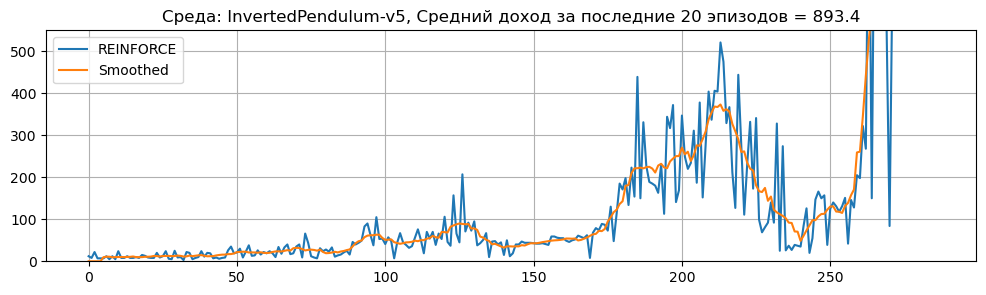

In [53]:
# сглаженный вектор доходов
gains_smoothed = np.pad(np.convolve(gains, np.ones(10)/10, mode='valid'),[5, 0])

fig = plt.figure(figsize=(12, 3))
plt.title("Среда: "+ "InvertedPendulum-v5" +", Средний доход за последние 20 эпизодов = "+str(np.mean(gains[-20:])))
plt.plot(gains, label="REINFORCE")
plt.plot(gains_smoothed, label="Smoothed")
plt.grid()
plt.legend()
plt.ylim(0, 550)
plt.show()

Проверим работу агента.

In [57]:
# создание экземпляра среды
env = gym.make("InvertedPendulum-v5", render_mode = "human")

state, _ = env.reset()
terminated, truncated = False, False
gain = 0

# демонстрация работы агента
while not terminated and not truncated:
    action = agent.best_action(state)
    # выбор действия по обученной Q функции
    state, reward, terminated, truncated, _ = env.step(action) 
    gain += reward
print("Доход:", gain)
# завершить взаимодействие со средой
env.close()

Доход: 1000


### Пример 2

Рассмотрим работу метода на примере среды "Pendulum-v1". В этой среде смоделирована задача о раскачивании перевернутого маятника. Система состоит из маятника, прикрепленного одним концом к неподвижной точке, другой конец свободен. Маятник начинает качаться в произвольном положении. Цель состоит в том, чтобы приложить крутящий момент, чтобы повернуть его в вертикальное положение с центром тяжести прямо над фиксированной точкой.

На диаграмме ниже указана система координат, используемая для реализации динамических уравнений маятника.

Подробности по ссылке:

    https://gymnasium.farama.org/environments/classic_control/pendulum/

In [59]:
env = gym.make("Pendulum-v1")
print(env.observation_space)
print(env.action_space)

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Box(-2.0, 2.0, (1,), float32)


In [61]:
# создание экземпляра среды
env = gym.make("Pendulum-v1", render_mode = "human")

state, _ = env.reset()
terminated, truncated = False, False
gain = 0

# демонстрация работы агента
while not terminated and not truncated:
    action = env.action_space.sample()
    # выбор действия по обученной Q функции
    state, reward, terminated, truncated, _ = env.step(action) 
    gain += reward
print("Доход:", gain)
# завершить взаимодействие со средой
env.close()

Доход: -1596.956122064166


Создадим сеть и обучим агента.

In [63]:
class PiNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PiNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.fc4 = nn.Linear(64, action_dim)

        
    def forward(self, state):
        x = self.fc1(state)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        
        action_means = self.fc3(x)
        action_stds = self.fc4(x)
        action_stds = torch.log(1 + torch.exp(action_stds))
        
        cov_mat = torch.diag(action_stds * action_stds)
        dist = MultivariateNormal(action_means, cov_mat)
        return dist

In [67]:
env = gym.make("Pendulum-v1")

model = PiNetwork(env.observation_space.shape[0], env.action_space.shape[0])

agent = REINFORCE_Agent(env, model, alpha = 0.0002, entropy_coef = 0.01)

state, _ = env.reset()
print(state)
agent.best_action(state)

[0.80229986 0.59692127 0.06130092]


array([-0.3999429], dtype=float32)

In [69]:
gains = REINFORCE_control(env, agent, num_episodes=1500, goal_score=-300)

Эпизод: 0, Средний доход за 100 эпизодов: -1657.0037357500282
Эпизод: 10, Средний доход за 100 эпизодов: -1318.7486836783382
Эпизод: 20, Средний доход за 100 эпизодов: -1244.9183659756138
Эпизод: 30, Средний доход за 100 эпизодов: -1272.226222326756
Эпизод: 40, Средний доход за 100 эпизодов: -1269.1978473274103
Эпизод: 50, Средний доход за 100 эпизодов: -1283.8507278583033
Эпизод: 60, Средний доход за 100 эпизодов: -1299.5476454006582
Эпизод: 70, Средний доход за 100 эпизодов: -1291.5096750607972
Эпизод: 80, Средний доход за 100 эпизодов: -1292.4949215762995
Эпизод: 90, Средний доход за 100 эпизодов: -1289.9438779171423
Эпизод: 100, Средний доход за 100 эпизодов: -1273.3231394995435
Эпизод: 110, Средний доход за 100 эпизодов: -1266.1468720941639
Эпизод: 120, Средний доход за 100 эпизодов: -1270.4461465798483
Эпизод: 130, Средний доход за 100 эпизодов: -1258.2777060852366
Эпизод: 140, Средний доход за 100 эпизодов: -1258.8138688110091
Эпизод: 150, Средний доход за 100 эпизодов: -1239.58

KeyboardInterrupt: 

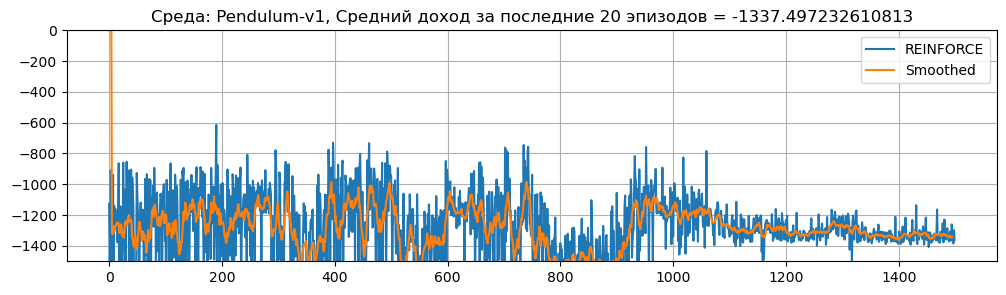

In [23]:
# сглаженный вектор доходов
gains_smoothed = np.pad(np.convolve(gains, np.ones(10)/10, mode='valid'),[5, 0])

fig = plt.figure(figsize=(12, 3))
plt.title("Среда: "+ "Pendulum-v1" +", Средний доход за последние 20 эпизодов = "+str(np.mean(gains[-20:])))
plt.plot(gains, label="REINFORCE")
plt.plot(gains_smoothed, label="Smoothed")
plt.grid()
plt.legend()
plt.ylim(-1500, 0)
plt.show()

In [24]:
# создание экземпляра среды
env = gym.make("Pendulum-v1", render_mode = "human")

state, _ = env.reset()
terminated, truncated = False, False
gain = 0

# демонстрация работы агента
while not terminated and not truncated:
    action = agent.best_action(state)
    # выбор действия по обученной Q функции
    state, reward, terminated, truncated, _ = env.step(action) 
    gain += reward
print("Доход:", gain)
# завершить взаимодействие со средой
env.close()

Доход: -1352.1152346950605
